In [2]:
import pandas as pd
import re

In [3]:
data_dir = '../data/'

#### How much are phytochemicals in drugs?

In [8]:
drug_ingredients = pd.read_csv(data_dir + 'drugbank/drug_id_name_map.csv', index_col=[0])
drug_ingredients.head()

,id,drug_name
1,DB00001,Lepirudin
2,DB00002,Cetuximab
3,DB00003,Dornase alfa
4,DB00004,Denileukin diftitox
5,DB00005,Etanercept


In [4]:
with open(data_dir + 'phytochemicals.txt', 'r') as f:
    lines = f.readlines()  

phytochemicals = [re.sub('\n', '', x) for x in lines]   
phytochemicals = [x.lower() for x in phytochemicals] 

print(phytochemicals[:10])
phytochemicals = set(phytochemicals)

['phytoene', 'zeaxanthin', 'lentinan', 'farnesyl pyrophosphate', 'pentose', 'carotene, gamma', 'theogallin', 'pectin', 'cembrene', 'pimaric acid']


In [5]:
drug_names = set(drug_ingredients.drug_name)

drugs_with_phytochemicals = dict()
phytochemicals_in_drugs = set()

phytochemicals = list(phytochemicals)

for drug_name in drug_names:
    ingredient = drug_name.lower()

    if ingredient in phytochemicals:
        drugs_with_phytochemicals[drug_name] = phytochemicals.index(ingredient)
        phytochemicals_in_drugs.add(ingredient)


print(phytochemicals_in_drugs)
print()
print('Number of drugs that contains phytochemicals:', len(drugs_with_phytochemicals), '/ out of', len(drug_names))

{'zeaxanthin', 'tocopherol', 'cholecalciferol', 'testosterone', 'rutin', 'tannic acid', 'pectin', 'geraniol', 'phenylalanine', 'phenol', 'curcumin', 'thymol', 'lycopene', 'beta carotene', 'tyrosine', 'betulinic acid', 'menthol', 'inulin', 'camphor', 'tryptophan', 'capsaicin', 'hesperidin', 'cholesterol', 'paclitaxel', 'salicylic acid', 'lutein'}

Number of drugs that contains phytochemicals: 26 / out of 4225


### Data Analysis
(in training dataset)

#### Drugs

In [6]:
drug_inchi_key = pd.read_csv(data_dir + 'triplets/drugs_inchi_key.tsv', sep='\t', index_col=[0])
print(drug_inchi_key.head(3))
print()


drug_subclass = pd.read_csv(data_dir + 'triplets/drug_subclass.tsv', sep='\t', index_col=[0])
print(drug_subclass.head(3))
print()

drug_salts = pd.read_csv(data_dir + 'triplets/drug_salts.tsv', sep='\t', index_col=[0])
print(drug_salts.head(3))
print()

drug_ingredients = pd.read_csv(data_dir + 'triplets/ingredients.tsv', sep='\t', index_col=[0])
print(drug_ingredients.head(3))
print()

drug_interactions = pd.read_csv(data_dir + 'triplets/ddi.tsv', sep='\t', index_col=[0])
print(drug_interactions.head(3))
print()

        id       relation                    inchi_key
1  DB00006  has_inchi_key  OIRCOABEOLEUMC-GEJPAHFPSA-N
2  DB00007  has_inchi_key  GFIJNRVAKGFPGQ-LIJARHBVSA-N
3  DB00014  has_inchi_key  BLCLNMBMMGCOAS-URPVMXJPSA-N

        id     relation subclass
1  DB00001  in_subclass  class_0
2  DB00002  in_subclass  class_0
3  DB00003  in_subclass  class_0

      drug  relation       salt_id
1  DB00007  contains  DBSALT000105
2  DB00007  contains  DBSALT003182
3  DB00010  contains  DBSALT001439

   drug_name  relation ingredient
0   refludan  contains    DB00001
1    erbitux  contains    DB00002
2  pulmozyme  contains    DB00003

     drug1                        interaction    drug2
0  DB06605  increase_anticoagulant_activities  DB00001
1  DB06695  increase_anticoagulant_activities  DB00001
2  DB01254                  increase_bleeding  DB00001



#### Food

In [15]:
food_compounds = pd.read_csv(data_dir + 'triplets/food_compound.tsv', sep='\t', index_col=[0])
print(food_compounds.head())
print()

compounds_cas_num = pd.read_csv(data_dir + 'triplets/compounds_cas_number.tsv', sep='\t', index_col=[0])
print(compounds_cas_num.head())
print()

     food_id  relation compound_id
0  FOOD00001  contains   FDB013255
1  FOOD00001  contains   FDB011904
2  FOOD00002  contains   FDB014613
3  FOOD00002  contains   FDB008322
4  FOOD00002  contains   FDB000474

  compound_id        relation cas_number
0   FDB009065  has_cas_number    79-92-5
1   FDB005805  has_cas_number   475-20-7
2   FDB003713  has_cas_number  7440-21-3
3   FDB008738  has_cas_number   108-46-3
4   FDB012485  has_cas_number    98-92-0



#### Drug Supplements

In [ ]:
ds_ingredients = pd.read_csv(data_dir + 'triplets/ds_ingredients.tsv', sep='\t', index_col=[0])
print(ds_ingredients.head())
print()

ds_relations = pd.read_csv(data_dir + 'triplets/ds_relations.tsv', sep='\t', index_col=[0])
print(ds_relations.head())
print()

## Graph visualization

In [8]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import torch_geometric.transforms as T
from torch_geometric.data import Data
import networkx as nx
from networkx.algorithms import community
from ogb.linkproppred import Evaluator, PygLinkPropPredDataset
import random
import itertools
from operator import itemgetter

In [ ]:
!pip3 install pyvis

In [3]:
from pyvis.network import Network

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### BioKG

In [8]:
dataset_dir = '../data/dataset-ogb/'

dataset = PygLinkPropPredDataset(name='ogbl-ddi', root=dataset_dir, transform=T.ToSparseTensor())
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of nodes: 4267
Number of edges: 2135822


In [10]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
train_edge

{'edge': tensor([[4039, 2424],
         [4039,  225],
         [4039, 3901],
         ...,
         [ 647,  708],
         [ 708,  338],
         [ 835, 3554]])}

In [9]:
def random_sample(edge_index, num_nodes, k=10):
    nodes_idx = random.sample(range(num_nodes), k)
    mask = torch.from_numpy(np.isin(edge_index, nodes_idx).sum(axis=0) > 0)
    mask = mask.expand(2,-1)

    # select just edges with generated node index (nodes_idx)
    edge_index_sample = edge_index * mask 

    # get rid of 0s columns
    non_empty_mask = edge_index_sample.sum(dim=0).bool()
    edge_index_sample = edge_index_sample[:,non_empty_mask]
    
    return edge_index_sample

In [14]:
edge_index_sample = random_sample(torch.transpose(train_edge['edge'], 0, 1), data.num_nodes)
edge_index_sample

tensor([[4039, 4039, 4039,  ..., 2048, 2048, 2048],
        [ 308, 2488, 2048,  ..., 1741, 1061,  708]])

In [15]:
num_nodes = edge_index_sample.unique()
# num_nodes.size(0)
data = Data(edge_index=edge_index_sample, num_nodes=num_nodes.size(0))
data

Data(edge_index=[2, 7291], num_nodes=2463)

In [16]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
index = 225
edge_example_outward = edge_index_sample[:, np.where(edge_index_sample[0]==index)[0]]
edge_example_inward = edge_index_sample[:, np.where(edge_index_sample[1] == index)[0]]
edge_example_outward

(2, 7291)


tensor([[ 225,  225,  225],
        [ 811,  308, 2048]])

In [17]:
edge_example_inward.shape

torch.Size([2, 0])

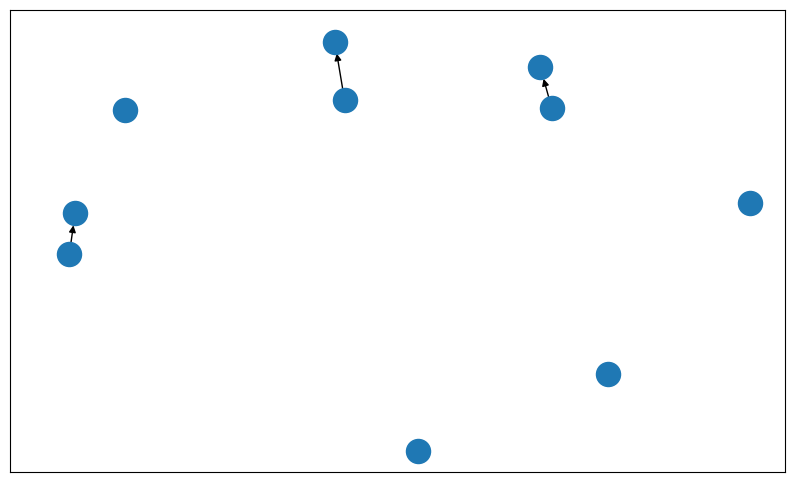

In [21]:
node_example = np.unique(np.concatenate(
    [edge_example_outward.flatten(), edge_example_inward.flatten()]))
plt.figure(figsize=(10, 6))
G = nx.DiGraph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example_outward[0], edge_example_outward[1])))
G.add_edges_from(list(zip(edge_example_inward[0], edge_example_inward[1])))
nx.draw_networkx(G, with_labels=False)

In [20]:
def visuzlize_graph(data):
    G = to_networkx(data, to_undirected=False)
    pos = nx.spring_layout(G, seed=42)
    cent = nx.degree_centrality(G)
    node_size = list(map(lambda x: x * 800, cent.values()))
    cent_array = np.array(list(cent.values()))
    threshold = sorted(cent_array, reverse=True)[10]
    print("threshold", threshold)
    cent_bin = np.where(cent_array >= threshold, 1, 0.1)
    plt.figure(figsize=(12, 12))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                   cmap=plt.cm.viridis,
                                   node_color=cent_bin,
                                   nodelist=list(cent.keys()),
                                   alpha=cent_bin)
    labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
    edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.6)
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_names, font_color='red', font_size=12, font_weight='normal')
    plt.show()

### DrugBank data

In [4]:
my_data = 'triplets/train_drugbank.tsv'
data_df = pd.read_csv(data_dir + my_data, sep='\t')
data_df = data_df.dropna()

In [5]:
nodes = data_df[['head', 'tail']].stack().unique()
print('Number of unique nodes:', len(nodes))
nodes_map = {node: i for i, node in enumerate(nodes)}

edges = data_df['relation'].unique()
edges_map = {edge: i for i, edge in enumerate(edges)}
print('Number of unique edges:', len(edges))

Number of unique nodes: 9981
Number of unique edges: 6


In [6]:
heads = data_df['head'].map(nodes_map)
tails = data_df['tail'].map(nodes_map)

In [9]:
edges = torch.tensor([heads.values, tails.values])

/tmp/ipykernel_228/1872461729.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edges = torch.tensor([heads.values, tails.values])


In [10]:
IDX = 'DB00008'
node_id = nodes_map[IDX]

In [11]:
def random_sample(G, k=100):
    sampled_nodes = random.sample(G.nodes, k)
    return G.subgraph(sampled_nodes)
    

data_graph = Data(edge_index=edges, num_nodes=len(nodes))
G = to_networkx(data_graph, to_undirected=False)
G_subgraph = random_sample(G)

In [14]:
def particular_sample(nodes_idx, edge_index):
    mask = torch.from_numpy(np.isin(edge_index, nodes_idx).sum(axis=0) > 0)
    mask = mask.expand(2,-1)

    # select just edges with generated node index (nodes_idx)
    edge_index_sample = edge_index * mask 

    # get rid of 0s columns
    non_empty_mask = edge_index_sample.sum(dim=0).bool()
    edge_index_sample = edge_index_sample[:,non_empty_mask]
    
    return edge_index_sample

In [15]:
# edges_sample = random_sample(edges, len(nodes), k=5)
edges_sample = particular_sample([node_id], edges)
print(edges_sample)
num_nodes = edges_sample.unique()
print('number of unique nodes:', num_nodes.size(0))
data_sample = Data(edge_index=edges_sample, num_nodes=num_nodes.size(0))
# visuzlize_graph(data_sample)

tensor([[1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172,
         1172, 1172, 1172, 1

## Analyze the training data (graph)

- number of drug-drug or drug-food realtions in training data 
- node degree
- number of node types
- number of edges
- connections of enzymes/pathways to drugs

In [31]:
# number of drug-drug or drug-food realtions in training data

data_df['node_type'] = list(itertools.repeat('xxx', data_df.shape[0]))
data_df.loc[data_df['tail'].str.contains("DB\d+", regex=True), 'node_type'] = "drug"
data_df.loc[data_df['tail'].str.contains("FOOD"), 'node_type'] = "food"
data_df = data_df.loc[data_df['node_type'] != 'xxx']
data_df

,head,relation,tail,node_type
0,DB00224,increase_hyperbilirubinemia,DB01072,drug
1,DB04948,increase_hypotension,DB00869,drug
2,DB02925,increase_hypotension,DB00691,drug
3,DB01275,increase_hypotension,DB00869,drug
4,DB09026,increase_hypotension,DB00373,drug
...,...,...,...,...
1680571,DB00918,drug-drug_viral_infectious_disease,DB00996,drug
1680572,DB00502,drug-drug_viral_infectious_disease,DB00575,drug
1680573,DB01016,drug-drug_viral_infectious_disease,DB01023,drug
1680574,DB00787,drug-drug_viral_infectious_disease,DB01156,drug


In [43]:
dd_interactions_count = data_df[(data_df['node_type'] == 'drug') & (data_df['head'].str.match(r'DB\d+'))].shape[0]
df_interactions_count = data_df[(data_df['node_type'] == 'food') & (data_df['head'].str.match(r'DB\d+'))].shape[0]

print(f'Number of drug-drug relations in training data: {dd_interactions_count}')
print(f'Number of drug-food relations in training data: {df_interactions_count}')

Number of drug-drug relations in training data: 1654088
Number of drug-food relations in training data: 1723


,count,mean,std,min,25%,50%,75%,max
0,33079.0,95.29,328.42,1.0,2.0,5.0,25.0,3891.0


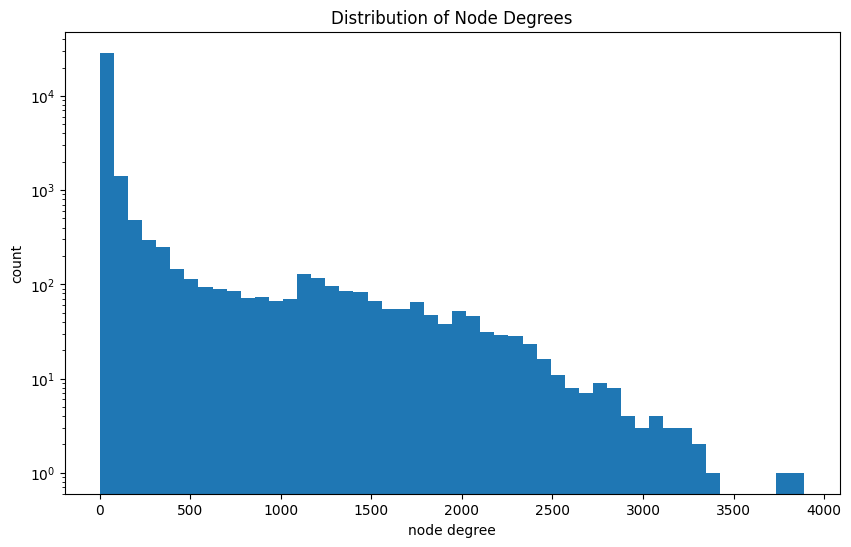

In [19]:
data = Data(edge_index=edges, num_nodes=len(nodes))

G = to_networkx(data, to_undirected=False)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
# print(len(degrees))
# print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.ylabel("count")
plt.yscale('log')
plt.title('Distribution of Node Degrees')
plt.show()

In [70]:
# node type distribution

# DB... - drug
# FOOD... - food
# FDB... - food compound
# cas number
# DBSALT... - drug salt
# subclass
# protein_...
# sideeffect_...
# disease_...
# SMP... - pathway
# pathway category 
# P/Q... - enzyme

# 12 types of nodes
nodes_list = data_df[['head', 'tail']].stack().unique()
nodes_df = pd.DataFrame({'node_id': nodes_list})

# it may be incorrect in some cases ??
nodes_df['node_type'] = list(itertools.repeat('cas_num', nodes_df.shape[0]))
nodes_df.loc[nodes_df['node_id'].str.contains("DB"), 'node_type'] = "drug"
nodes_df.loc[nodes_df['node_id'].str.contains("FOOD"), 'node_type'] = "food"
nodes_df.loc[nodes_df['node_id'].str.contains("FDB"), 'node_type'] = "food_compound"
nodes_df.loc[nodes_df['node_id'].str.contains("DBSALT"), 'node_type'] = "salt"
nodes_df.loc[nodes_df['node_id'].str.contains("class"), 'node_type'] = "drug_class"
nodes_df.loc[nodes_df['node_id'].str.contains("protein"), 'node_type'] = "protein"
nodes_df.loc[nodes_df['node_id'].str.contains("sideeffect"), 'node_type'] = "side_effect"
nodes_df.loc[nodes_df['node_id'].str.contains("disease"), 'node_type'] = "disease"
nodes_df.loc[nodes_df['node_id'].str.contains("SMP"), 'node_type'] = "pathway"
nodes_df.loc[nodes_df['node_id'].str.contains("pathway_cat"), 'node_type'] = "pathway_category"
nodes_df.loc[nodes_df['node_id'].str.contains("^[OPQ]\d+", regex=True), 'node_type'] = "enzyme"

nodes_df_grouped = nodes_df.groupby(by=['node_type']).count()
nodes_df_grouped.columns = ['count']
nodes_df_grouped = nodes_df_grouped.sort_values(by='count', ascending=False)
nodes_df_grouped

,count
node_type,
protein,13257
side_effect,8777
drug,2976
cas_num,2022
salt,1849
disease,1032
enzyme,1021
food,798
pathway,758


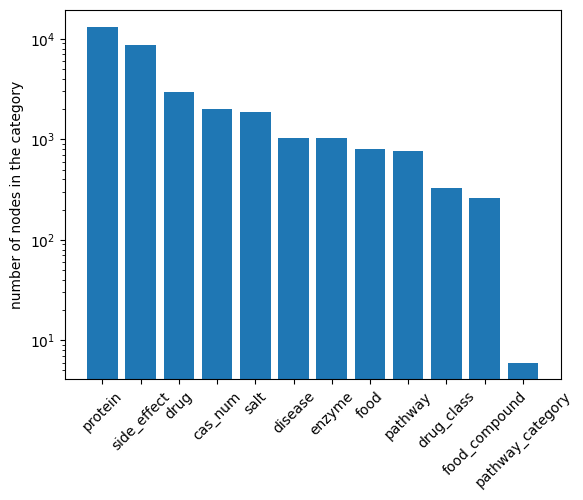

In [82]:
counts = nodes_df_grouped['count'].values
node_types = nodes_df_grouped.index

plt.bar(node_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of nodes in the category')
plt.show()

In [21]:
# edge type distribution
edge_types_grouped = data_df.groupby(by=['relation']).count()
edge_types_grouped = edge_types_grouped.drop(columns=['tail'])
edge_types_grouped.columns = ['count']
edge_types_grouped = edge_types_grouped.sort_values(by='count', ascending=False)
edge_types_grouped

,count
relation,
increase_serum_concentration,248592
decrease_excretion_rate,220665
decrease_metabolism,169663
protein-protein_reaction,145498
increase_adverse_effects,134405
...,...
increase_hypercoagulability,1
increase_dermatologic_adverse_activities,1
increase_skeletal_muscle_relaxing_activities,1


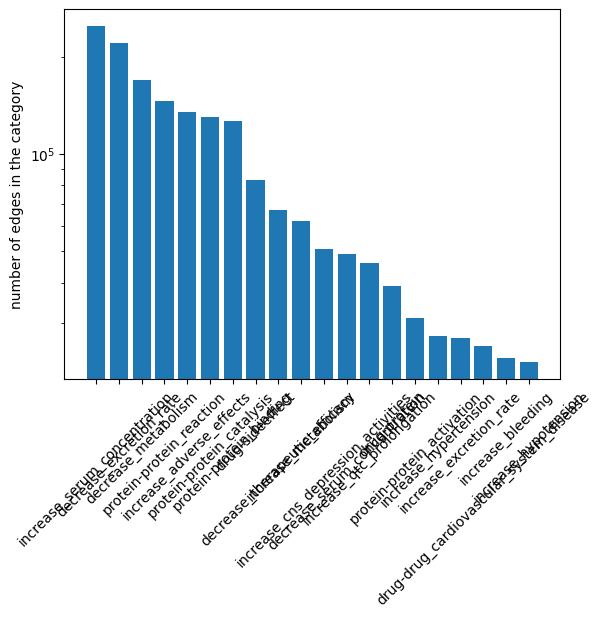

In [23]:
counts = list(edge_types_grouped['count'].values)[:20]
edge_types = list(edge_types_grouped.index)[:20]

plt.bar(edge_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of edges in the category')
plt.show()

In [8]:
# relations_unique = data_df.relation.unique()
# with open('unique_relations.txt', 'w') as f:
#     for rel in relations_unique:
#         f.write(rel + '\n')

In [ ]:
# connections of enzymes/pathways to drugs

In [ ]:
# vizualiztion for a specific drug(s)

In [2]:
# if we devide the interaction to positive and negative or both (depends on context/drugs)
labels = pd.read_csv('../data/unique_relations-labeled.csv', sep=';')

labels.groupby(by=['positive/negative']).count()

,relation
positive/negative,
both (depends on context),11
both (depends on drugs),16
negative,151
positive,25


Following code from https://github.com/kennethleungty/Drug-Interactions-Network-Analysis-and-Visualization/blob/main/02_Network_Analysis_and_Visualization.ipynb

In [10]:
# Generate a networkx graph
G = nx.from_pandas_edgelist(data_df, 'head', 'tail')

# Give the graph a name
G.name = 'Drug Interactions Network'

# Check whether graph is directed or undirected (False = undirected)
print(G.is_directed())

# Obtain general information of graph
# print(nx.info(G))

# Get graph density
density = nx.density(G)
print("Network density:", density)

False
Network density: 0.20106544410040156


In [11]:
# Create dictionary to store degrees of nodes
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

# Generate sorted list of tuples of drug entity and corresponding degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 drugs by degree:")
for d in sorted_degree[:10]:
    d_name = drug_ingredients[drug_ingredients['id'] == d[0]].drug_name.values[0]
    print(d, d_name)

Top 20 drugs by degree:
('DB00908', 1619) Quinidine
('DB00363', 1617) Clozapine
('DB00477', 1599) Chlorpromazine
('DB00091', 1571) Cyclosporine
('DB00458', 1568) Imipramine
('DB00321', 1561) Amitriptyline
('DB00564', 1541) Carbamazepine
('DB09241', 1537) Methylene blue
('DB01149', 1527) Nefazodone
('DB00502', 1527) Haloperidol


In [13]:
# Get degree centrality (corresponds with degree)
degree_centrality = nx.degree_centrality(G)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
degree_centrality

{'DB00908': 0.6316816230979321,
 'DB00363': 0.630901287553648,
 'DB00477': 0.6238782676550917,
 'DB00091': 0.6129535700351151,
 'DB00458': 0.6117830667186891,
 'DB00321': 0.6090518923136949,
 'DB00564': 0.6012485368708544,
 'DB09241': 0.5996878657822864,
 'DB01149': 0.5957861880608661,
 'DB00502': 0.5957861880608661,
 'DB01142': 0.5879828326180258,
 'DB00176': 0.5852516582130316,
 'DB00909': 0.5821303160358955,
 'DB00661': 0.5793991416309013,
 'DB01242': 0.5774483027701912,
 'DB04896': 0.5657432696059306,
 'DB00270': 0.5645727662895045,
 'DB01151': 0.5634022629730784,
 'DB01224': 0.5626219274287944,
 'DB01267': 0.5610612563402263,
 'DB06700': 0.5591104174795162,
 'DB00312': 0.5583300819352321,
 'DB01115': 0.5579399141630902,
 'DB08910': 0.5520873975809598,
 'DB00280': 0.5516972298088179,
 'DB00864': 0.5458447132266875,
 'DB00622': 0.5446742099102614,
 'DB00398': 0.5442840421381194,
 'DB00285': 0.5419430355052672,
 'DB00333': 0.5407725321888412,
 'DB09118': 0.538431525555989,
 'DB00468'

In [59]:
# Define function to generate Pyvis visualization
def generate_network_viz(df, source_col, target_col, 
                         layout='repulsion',
                         central_gravity=0.15,
                         node_distance=420,
                         spring_length=100,
                         spring_strength=0.15,
                         damping=0.96
                         ):
    
    # Generate a networkx graph
    G = nx.from_pandas_edgelist(df, source_col, target_col)
    
    if layout == 'repulsion':
        bgcolor, font_color = '#222222', 'white'
    else:
        bgcolor, font_color = 'white', 'black'
    
    # Initiate PyVis network object
    drug_net = Network(
                       height='700px', 
                       width='100%',
                       bgcolor=bgcolor, 
                       font_color=font_color, 
                       notebook=True
                      )
    
    # Take Networkx graph and translate it to a PyVis graph format
    drug_net.from_nx(G)

    drug_net.repulsion(
                        node_distance=node_distance, 
                        central_gravity=central_gravity, 
                        spring_length=spring_length, 
                        spring_strength=spring_strength, 
                        damping=damping
                       )

    return drug_net

In [94]:
# reverse_nodes_map = dict((v, k) for k, v in nodes_map.items())
# edges_sample_names = [[],[]]
# for d in edges_sample[0]:
# #     print(d.item())
#     edges_sample_names[0].append(reverse_nodes_map[d.item()])
# for d in edges_sample[1]:
# #     print(d.item())
#     edges_sample_names[1].append(reverse_nodes_map[d.item()])  

node_name='DB04574'
temp = G.copy(as_view=False) # make a temporary graph to avoid losing original ones
nodelist = list(temp.neighbors(n=nodename)) #generate the nodes that have relationship with our target node
nodelist.append(nodename) # add the target to the list
Sub = temp.subgraph(nodelist) # draw subgraph
#     edges= *nx.get_edge_attributes(Sub).items()
edges = Sub.edges
edges

EdgeView([('DB01225', 'DB00783'), ('DB01225', 'DB04817'), ('DB01225', 'DB11095'), ('DB01225', 'DB01240'), ('DB01225', 'DB00498'), ('DB01225', 'DB01435'), ('DB01225', 'DB06695'), ('DB01225', 'DB13952'), ('DB01225', 'DB00176'), ('DB01225', 'DB00946'), ('DB01225', 'DB00715'), ('DB01225', 'DB01109'), ('DB01225', 'DB01424'), ('DB01225', 'DB00461'), ('DB01225', 'DB00533'), ('DB01225', 'DB06605'), ('DB01225', 'DB00675'), ('DB01225', 'DB04574'), ('DB01225', 'DB09255'), ('DB01225', 'DB13954'), ('DB01225', 'DB00436'), ('DB01225', 'DB00055'), ('DB01225', 'DB00999'), ('DB01225', 'DB01021'), ('DB01225', 'DB09241'), ('DB01225', 'DB01115'), ('DB01225', 'DB01015'), ('DB01225', 'DB01088'), ('DB01225', 'DB00775'), ('DB01225', 'DB00571'), ('DB01225', 'DB01418'), ('DB01225', 'DB00606'), ('DB01225', 'DB13953'), ('DB01225', 'DB08887'), ('DB01225', 'DB01166'), ('DB01225', 'DB04743'), ('DB01225', 'DB13532'), ('DB01225', 'DB04898'), ('DB01225', 'DB00806'), ('DB01225', 'DB00569'), ('DB01225', 'DB00562'), ('DB01

In [100]:
sample_df = pd.DataFrame(pd.DataFrame(edges), name={'head', 'tail'})
print(sample_df.shape)
sample_df.head()

TypeError: __init__() got an unexpected keyword argument 'names'

In [58]:
# Generate a networkx graph based on subset data
db_subset_net = generate_network_viz(sample_df, 'head', 'tail', layout='repulsion')

# Display interactive graph
db_subset_net.show('drug_interactions_network_subset_repulsion.html')


drug_interactions_network_subset_repulsion.html


In [89]:

def drawnodegraph(graph, nodename, info=False,weightbar=0):
      # graph will be your networkx graph
      # nodename will be the node that you want to focus on
      # the default value for weightbar is 0, if increase the bar, rare relationship will be removed. Assuming no negative weights
    temp = graph.copy(as_view=False) # make a temporary graph to avoid losing original ones
    temp.remove_edges_from((e for e, w in nx.get_edge_attributes(temp,'weight').items() if w <= weightbar)) # remove rare relationhsip if weightbar is not 0
    nodelist = list(temp.neighbors(n=nodename)) #generate the nodes that have relationship with our target node
    nodelist.append(nodename) # add the target to the list
    Sub = temp.subgraph(nodelist) # draw subgraph
#     edges= *nx.get_edge_attributes(Sub).items()
    edges = Sub.edges
    pos=nx.spring_layout(Sub,k=0.7,seed=42)
    node_map = {nodename:7000} 
    nodesize=[node_map.get(node, 3500) for node in Sub.nodes()] # enlarge our target node
    val_map = {nodename:0.5714285714285714}
    nodecolor = [val_map.get(node, 0.25) for node in Sub.nodes()] # change the color of our target node
#     width = [w*5 for w in weights] # change the edge's width based on the weights of the edges
    width = 1
    nx.draw_networkx(Sub,
                   pos,
                   cmap=plt.get_cmap('viridis'),
                   with_labels=True,
                   node_size=10,
                   node_color=nodecolor,
                   edgelist=edges, 
                   edge_color="blue",
                   #edge_cmap=plt.cm.Blues_r,
                   style="solid",
                   font_color='black',
                   font_size=14,
                   width =width)
    plt.subplots_adjust(left=2, bottom=3.2, right=6, top=6)

    if info:
        print("----------------------------------------")
        print("Density:",nx.classes.function.density(Sub))
        print("The information of the graph:",nx.info(Sub))
        print("----------------------------------------")

    return plt.show()

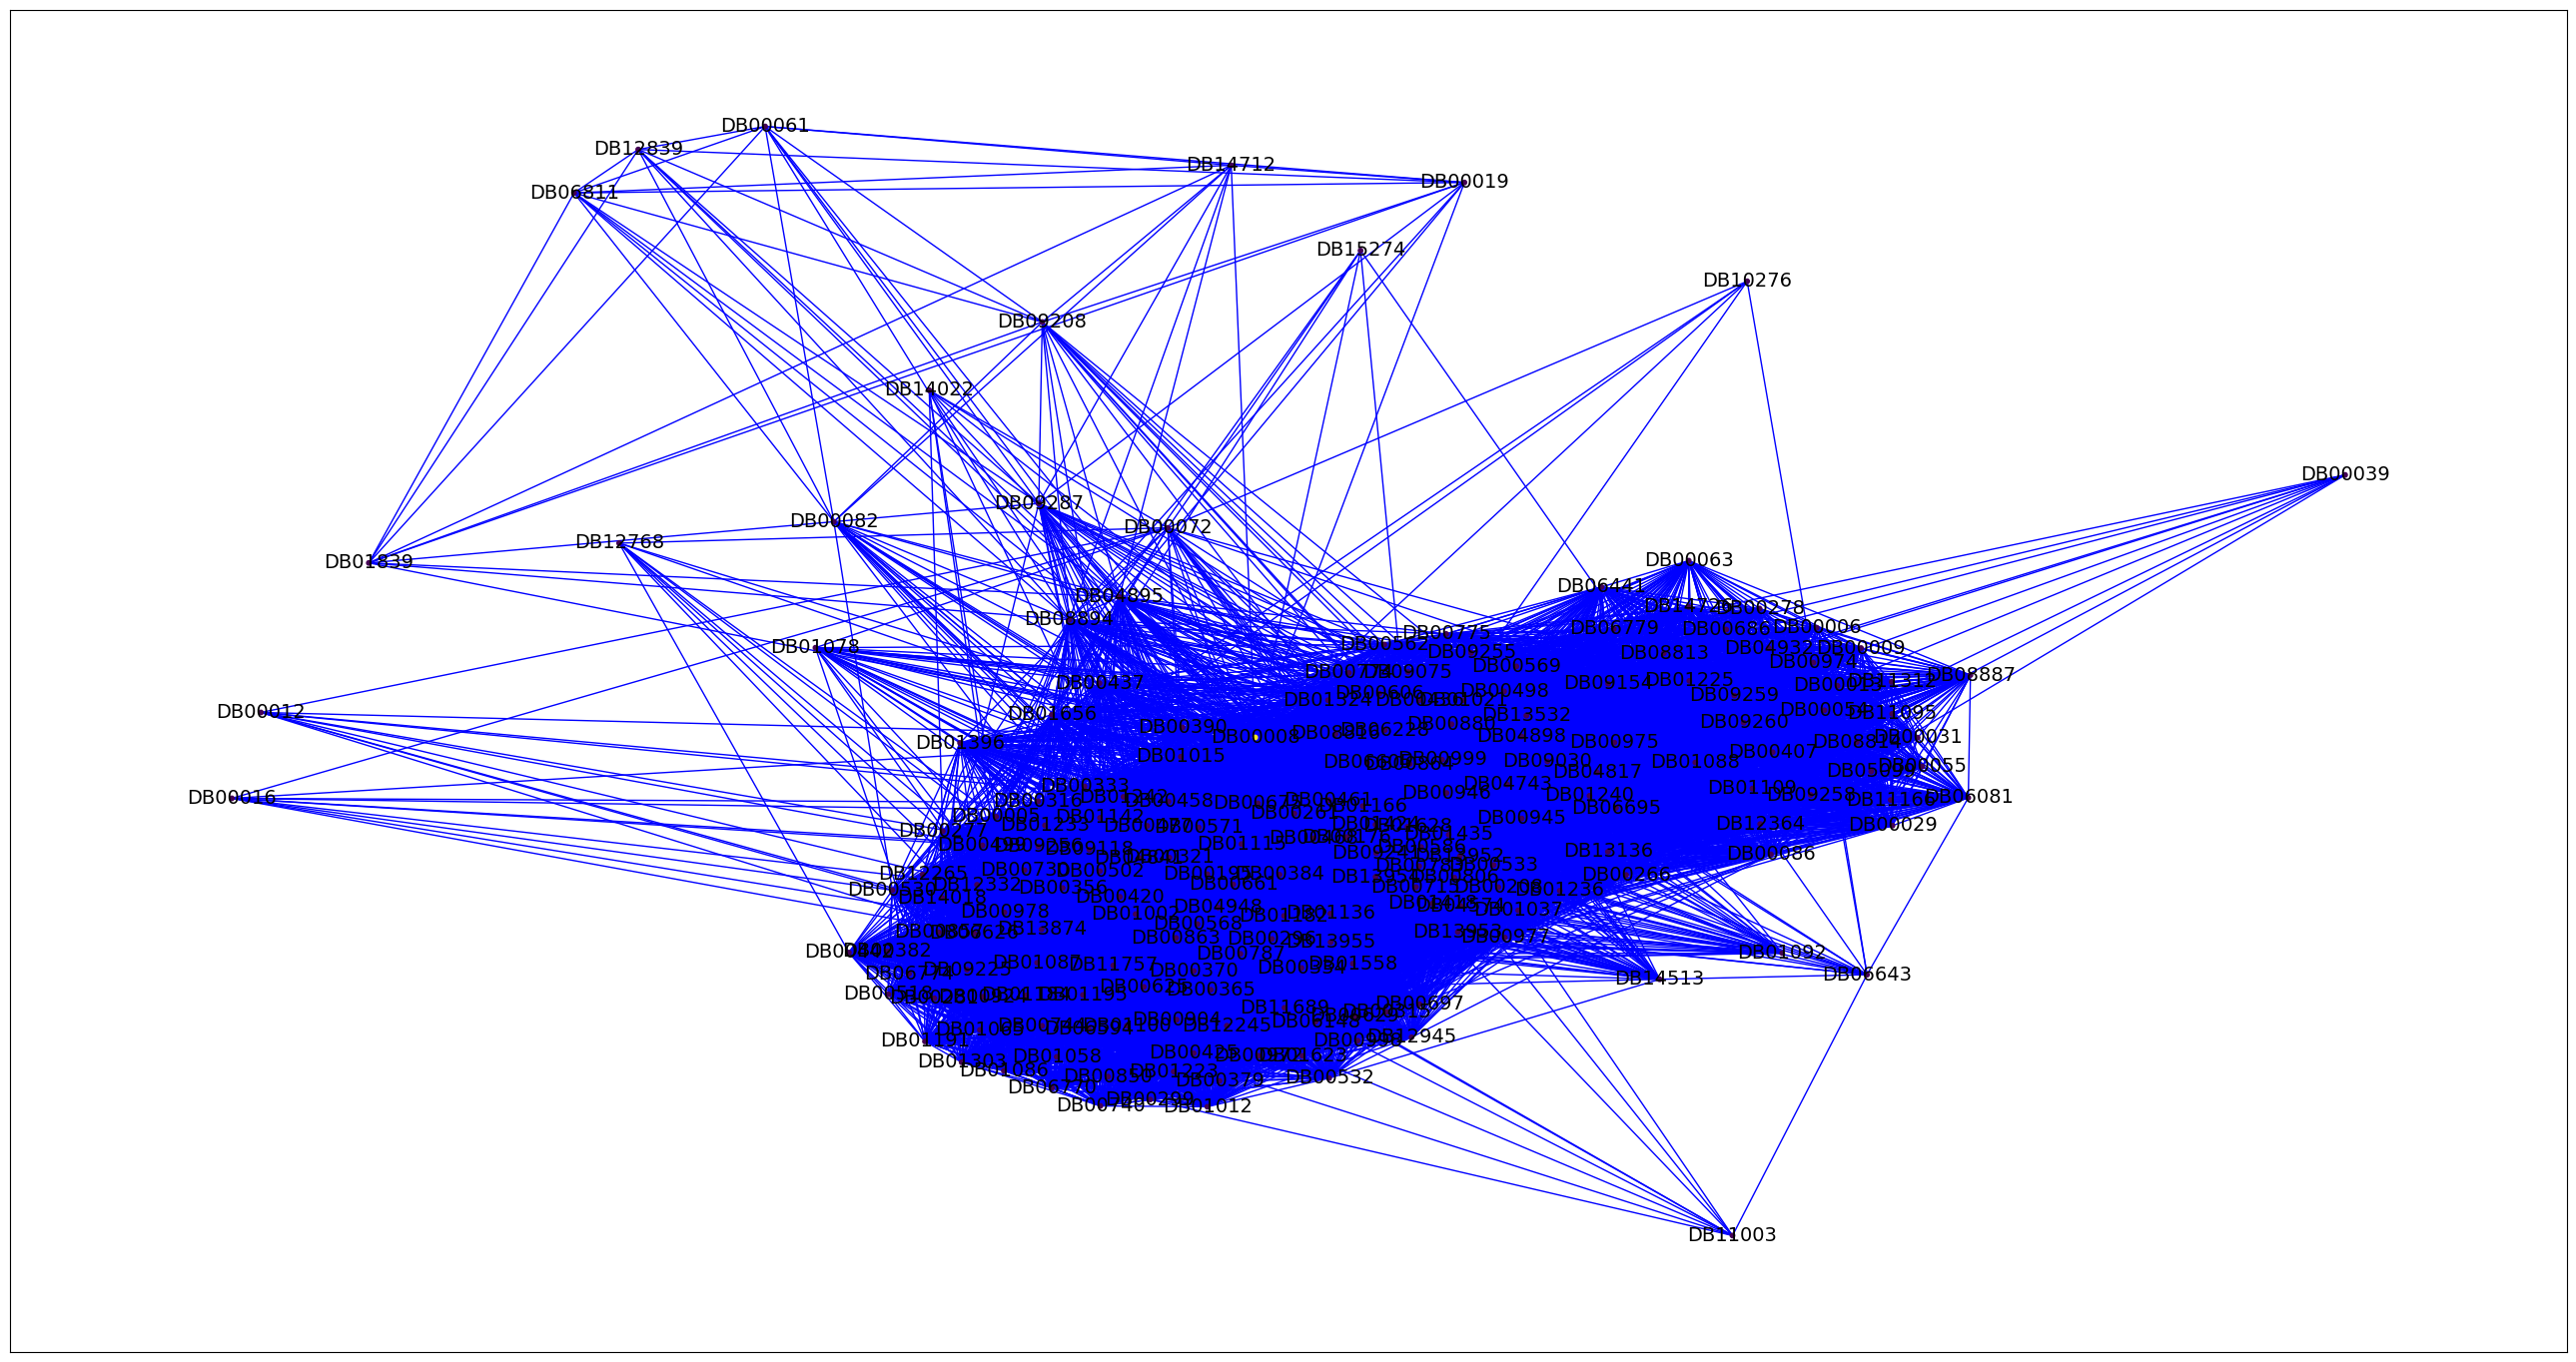

In [90]:
drawnodegraph(G, 'DB00008')